In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = [
    [99, 1.56], [95, 1.41], [99, 2.02], [88, 1.87],
    [95, 1.42], [73, 2.68], [81, 2.21], [90, 1.65],
    [68, 2.92], [85, 1.98], [79, 2.34], [93, 1.47],
    [71, 2.75], [87, 1.82], [96, 1.38], [82, 2.19]
]

df = pd.DataFrame(data, columns=['AccuracyPercent', 'AvgReactionTimeSec'])

# Manual labeling criteria
def label_performance(row):
    if row['AccuracyPercent'] >= 90 and row['AvgReactionTimeSec'] <= 1.7:
        return 'High'
    elif row['AccuracyPercent'] >= 80 and row['AvgReactionTimeSec'] <= 2.0:
        return 'Medium'
    else:
        return 'Low'

df['Performance'] = df.apply(label_performance, axis=1)

In [3]:
# 1. Efficiency Score (Accuracy/ReactionTime)
df['Efficiency'] = df['AccuracyPercent'] / df['AvgReactionTimeSec']

# 2. Speed-Accuracy Trade-off Index
mean_rt = df['AvgReactionTimeSec'].mean()
df['SAT_Index'] = df['AccuracyPercent'] * (mean_rt / df['AvgReactionTimeSec'])

# 3. Performance Z-scores
df['Accuracy_Z'] = (df['AccuracyPercent'] - df['AccuracyPercent'].mean()) / df['AccuracyPercent'].std()
df['RT_Z'] = (df['AvgReactionTimeSec'] - df['AvgReactionTimeSec'].mean()) / df['AvgReactionTimeSec'].std()

print("Statistical Features Summary:")
print(df[['Efficiency', 'SAT_Index', 'Accuracy_Z', 'RT_Z']].describe())

Statistical Features Summary:
       Efficiency   SAT_Index  Accuracy_Z          RT_Z
count   16.000000   16.000000   16.000000  1.600000e+01
mean    47.257180   93.539680    0.000000 -2.428613e-16
std     15.723153   31.122015    1.000000  1.000000e+00
min     23.287671   46.095034   -1.845180 -1.194569e+00
25%     35.928859   71.116685   -0.585671 -8.806679e-01
50%     47.430511   93.882767    0.119653 -1.083707e-01
75%     63.314364  125.322870    0.875358  5.244147e-01
max     69.565217  137.695652    1.278401  1.874689e+00


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target
X = df[['AccuracyPercent', 'AvgReactionTimeSec', 'Efficiency', 'SAT_Index']]
y = df['Performance']

# Split data (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize and train
nn = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)
nn.fit(X_train_scaled, y_train)

# Evaluate
y_pred_nn = nn.predict(X_test_scaled)
print("Neural Network Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nn))

Neural Network Confusion Matrix:
[[1 0 0]
 [0 2 0]
 [0 0 1]]

Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00         1
         Low       1.00      1.00      1.00         2
      Medium       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [6]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=42
)
rf.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nFeature Importances:")
for feat, imp in zip(X.columns, rf.feature_importances_):
    print(f"{feat}: {imp:.4f}")


Random Forest Confusion Matrix:
[[0 0 1]
 [0 2 0]
 [0 0 1]]

Feature Importances:
AccuracyPercent: 0.1383
AvgReactionTimeSec: 0.4175
Efficiency: 0.2476
SAT_Index: 0.1966


In [7]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder and fit on the training data labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


# Initialize and train
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
xgb.fit(X_train, y_train_encoded)

# Evaluate
y_pred_xgb = xgb.predict(X_test)
print("\nXGBoost Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred_xgb))


XGBoost Confusion Matrix:
[[1 0 0]
 [0 2 0]
 [1 0 0]]



Model Comparison:
Neural Network Accuracy: 1.00
Random Forest Accuracy: 0.75
XGBoost Accuracy: 0.75


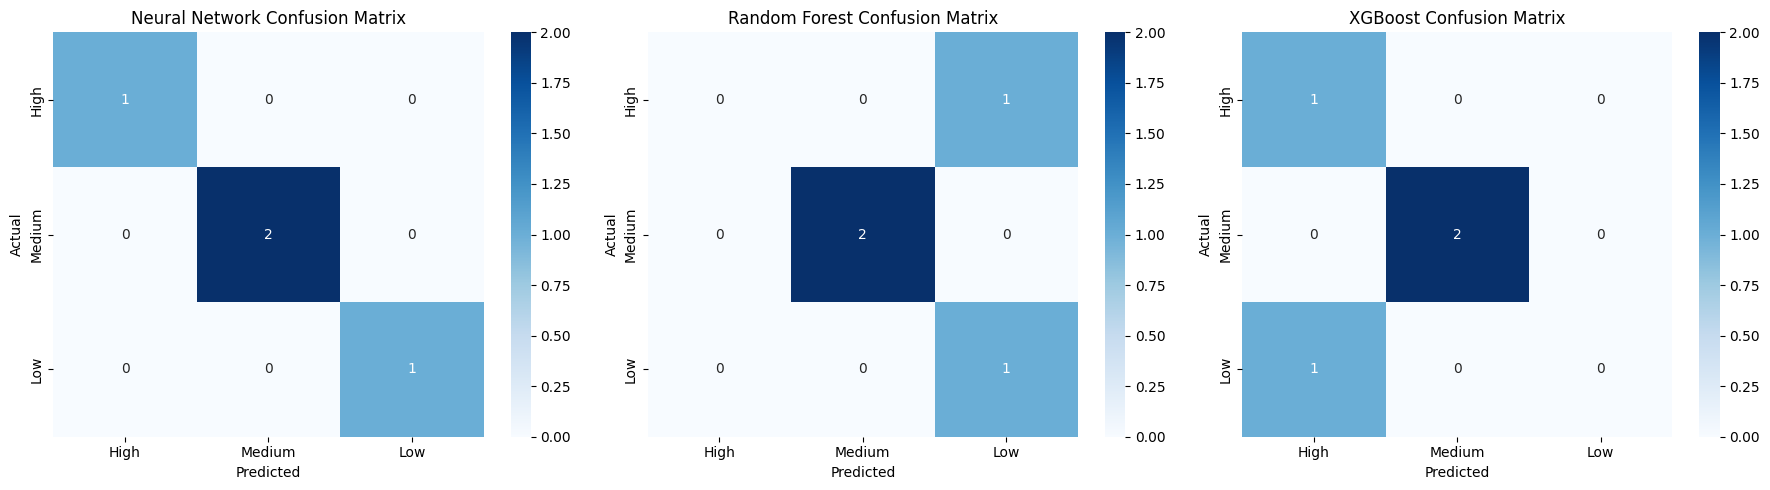

In [8]:
# Compile accuracy scores
nn_acc = nn.score(X_test_scaled, y_test)
rf_acc = rf.score(X_test, y_test)
xgb_acc = xgb.score(X_test, y_test_encoded)

print(f"\nModel Comparison:")
print(f"Neural Network Accuracy: {nn_acc:.2f}")
print(f"Random Forest Accuracy: {rf_acc:.2f}")
print(f"XGBoost Accuracy: {xgb_acc:.2f}")

# Plot confusion matrices
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

models = [('Neural Network', y_pred_nn),
          ('Random Forest', y_pred_rf),
          ('XGBoost', y_pred_xgb)]

for i, (name, pred) in enumerate(models):
    if name == 'XGBoost':
        cm = confusion_matrix(y_test_encoded, pred)
    else:
        cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax[i], cmap='Blues')
    ax[i].set_title(f'{name} Confusion Matrix')
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('Actual')
    ax[i].set_xticklabels(['High', 'Medium', 'Low'])
    ax[i].set_yticklabels(['High', 'Medium', 'Low'])

plt.tight_layout()
plt.show()